In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import scipy
import functools

import scipy

from sklearn import datasets
from sklearn.preprocessing import LabelBinarizer

In [2]:
# Some useful utilities
from mcmc_utils_and_plot import scatter_matrix, build_cov_mat, lognormpdf, plot_bivariate_gauss, eval_func_on_grid, sub_sample_data

def compose(*functions):
    "Compose a list of functions"
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

# Classifiers

Alex Gorodetsky, March 2024

The goals of this notebook are to 
1. Walk through the full process of setting up a learning problem and solving it
2. Introduce some implementation of an (inefficient) adaptive metropolis algorithm and Laplace Approximation
3. Provide some insight into Classification problems


In this notebook, consider a nonlinear inference problem -- and the algorithms to solve it. We begin with a multi-class classification problem. The problem is as follows. 

## Multi-class classification
Suppose that we have a dataset $D = \left\{(x^{(k)}, y^{(k)})\right\}_{k=1}^N$, were $x^{(k)} \in \mathbb{R}^d$ and $y^{(k)} \in \{1,2,\ldots, n\}$ are discrete valued out of $n$ possible choices. Our goal is to predict the class of other potential inputs $x \in \mathbb{R}^{d}$.  To make this concrete lets take a look at some sample dataset. 

We will use [scikit-learn](https://scikit-learn.org/stable/index.html) to generate some data from the "Iris" dataset, which has three classes

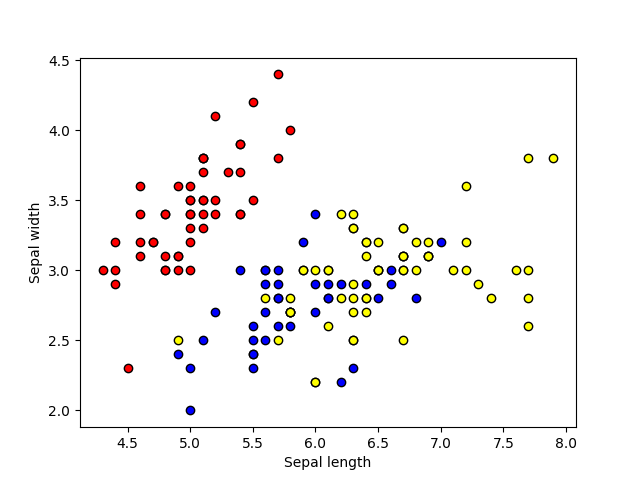

In [3]:
iris = datasets.load_iris()
X = iris.data[:, :2] # just take first two features
y = iris.target + 1 # add 1 so that targets are ordinal numbers

# colordict = {0: 'darkviolet', 1: 'darkgoldenrod', 2: 'olive'}
colordict = {0: 'red', 1: 'blue', 2: 'yellow'}
plt.close(1)
plt.figure(1)
for ii in range(3):
    inds = y==(ii+1)
    plt.scatter(X[inds, 0], X[inds, 1], c=colordict[ii], edgecolor="k", label=iris.target_names[ii])
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.show()

### The sampling distribution

We will use a parametric approach to perform this classification. We need to define a model and some parameters. The model will provide a sampling distribution. Now, there are several approaches to building a model for this sort of thing -- you can peruse scikit learn to get a sense of the different models. 

I begin by asking the question: what is the form of the prediction that we want? One approach is a probabilistic one, given an input $x$, I want to predict the probability of each possible outcome. In other words, I want some model

$$
\begin{equation}
p = \begin{bmatrix}
p_1 \\
p_2 \\
\vdots \\
p_{n}
\end{bmatrix} 
= 
\begin{bmatrix}
g_1(x; \theta) \\
g_2(x; \theta) \\
\vdots \\
g_{n}(x; \theta)
\end{bmatrix} 
=
g(x;\theta) 
\end{equation}
$$

where $p_i$ is the probability that the class is $i$. Note that we have $p_{n} = 1 - \sum_{i=1}^{n-1}$, so we really just need to predict for $n-1$ classes. Also note that if $n=2$ this exactly a model for the Bernoulli parameter $p$. In the multi-dimensional case, this is called a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution). Which is a special case of 1 sample of the [multinomial distribution](https://en.wikipedia.org/wiki/Categorical_distribution). We can now see that the sampling distribution would be the following
$$
\begin{equation}
P(y = i \mid x; \theta) = g_i(x;\theta)
\end{equation}
$$
where $g_i(x; \theta)$ is the $i$-th component of the prediction. 

We can now use this sampling distribution to write a likelihood model, and then take it's log. Here we have
$$
\begin{equation}
P(D \mid \theta) = \prod_{k=1}^N p(y^{(k)} \mid x^{(k)}, \theta) = \prod_{k=1}^N g_{y^{(k)}}(x^{(k)}; \theta)
\end{equation}
$$
where the probability distribution of interest is the one that corresponds to the $y^{(k)}$-th output of $g$. Now, this is a little bit inconvenient, because we want to take log's and not really consider components of $g$ separately. To this end we can _reinterpret_ each data point $y^{(k)}$ as a vector of size $n$. In particular instead of say $y^{(k)} \in \{1,\ldots,n\}$ we _encode_ the label in a vector of size $n$ that is all zeros except for the index to which the label belongs. For instance, if $y^{(k)} = 2$ we would have
$$
\begin{equation}
y^{(k)}=2 \rightarrow 
\begin{bmatrix}
0 \\
1 \\
0 \\
\vdots \\
0
\end{bmatrix}
\end{equation}
= \hat{y}^{(k)}
$$
This is called _one-hot coding_. So we will interpret $\hat{y}^{(k)}$ as the encoded label. Now the likelihood becomes a simple dot product
$$
\begin{equation}
P(D \mid \theta) = \prod_{k=1}^N p(y^{(k)} \mid x^{(k)}, \theta) = \prod_{k=1}^N g(x^{(k)}; \theta)^T \hat{y}^{(k)} = \prod_{k=1}^N \left[ \sum_{i=1}^n \left(g_i(x^{(k)}; \theta) \hat{y}_i^{(k)}\right) \right]
 = \prod_{k=1}^N \left[ \prod_{i=1}^n \left(g_i(x^{(k)}; \theta)\right)^{\hat{y}_i^{(k)}}\right]
\end{equation}
$$


Now we can take the log likelihood, which is needed for any optimization or sampling routine.
$$
\begin{equation}
\log \mathcal{L}(\theta) = \sum_{k=1}^N \left(\sum_{i=1}^n \hat{y}_{i}^{(k)} \log \left(g_i(x^{(k)}; \theta)\right)\right)
\end{equation}
$$
where we now have a nice set of summations that we can use within an optimization procedure (maximum likelihood) or inference procedure. Note that for every outer summation element, only one element of inner summation is nonzero. You can leverage this for efficiency. This optimization objective is called the **cross entropy** optimization objective.

In [4]:
#enc = LabelBinarizer(sparse_output=True) # sparse matrix format
enc = LabelBinarizer()
yhat = enc.fit_transform(y)
#print(yhat)

### The model
We have one final thing to resolve before we are ready to model -- what is this $g$? The difficulty is to ensure that $g$ can only ouput vectors that sum up to 1. This difficulty can be resolved by decomposing $g$ into two parts: a function on the reals $f:\mathbb{R}^{d} \to \mathbb{R}^{n}$ and some sort of thresholding-type function $\sigma:\mathbb{R}^n \to [0,1]^n$. We will then have

$$
\begin{equation}
g(x; \theta) = \sigma(f(x; \theta)).
\end{equation}
$$

Now we are free to choose whatever we want for $f$. We can choose a linear model, a neural network, a polynomial, whatever. However, $\sigma$ will generally be a nonlinear model -- so in any case, we will have a **nonlinear** inference problem for which we do not have a conjugate prior and so MCMC must be used. The thresholding function we will use is called a _softmax_ function 

$$
\begin{equation}
\sigma_i(f) = \frac{e^{f_i}}{\sum_{j=1}^n e^{f_j}}, \quad i=1,\ldots n
\end{equation}
$$
Notice that the output is therefore a vector of $n$ numbers that sum to 1, and $f_i$ are just outputs from our function $f$ that take any real value: We can now write our likelihood

$$
\begin{equation}
\log \mathcal{L}(\theta)  = \sum_{k=1}^N \left(
\sum_{j=1}^n \hat{y}_{i}^{(k)} \left[f_i(x^{(k)}; \theta) \right] - \log \sum_{\ell=1}^n e^{f_\ell(x^{(k)};\theta)} \right)
\end{equation}
$$

This has a nice interpretation, consider that a maximum likelihood or a maximum a-posteriori would want to maximize this function. What this means is that you want to maximize the value of the function $f_i$ _when it matches_ $\hat{y}_{i}$, but how do you penalize the components of $f_i$ that don't matter (since they are multiplied by 0 in the one-hot encoding? This penalty is expressed through the $\log$ term, which basically pushes each of the $f_i$ to be as small as possible so that the exponential is as close to zero as possible. Thus, we want to maximally discriminate between the labels!

Lets code up the predictor and the log-likelihood now.

In [5]:
def predictor(params, x, ffunc):
    """Predict a vector of probabilities for the class of an input, using a user-specified function.

    Inputs
    ------
    params: (p, ) parameters of the function ffunc
    x: (N, d) array of locations at which to predict
    ffunc: a callable f(x, params) -> reals^{N, n}

    Returns
    -------
    (predict, normalizers, fvals): The predicted probabilities (N, n) the normalization (N), and the func vals (N)

    Notes
    -----
    Uses a softmax to convert ffunc predictions to probabilities
    """

    N = x.shape[0]
    fvals = ffunc(x, params)
    predict = np.exp(fvals) # add for stability
    n = predict.shape[1]
    normalizer = np.sum(predict, axis=1)
    predict /= np.tile(normalizer[:, np.newaxis], (1, n))

    predict[normalizer==np.inf] = 0.0
    normalizer[normalizer==np.inf] = 1e20
    #print(np.sum(predict, axis=1))
    return predict, normalizer, fvals

def log_likelihood(params, x, yh, ffunc):
    """Compute the log likelihood of the data.

    Inputs
    ------
    params: (p, ) parameters of the function ffunc
    x: (N, d) array of locations at which we have training data
    yh: (N, n) one-hot encoded array of labels
    ffunc: a callable f(x, params) -> reals^{N,n}
    """

    _, normalizer, fvals = predictor(params, x, ffunc)

    #print("evals.shape = ", evals.shape)
    #print("yh.shape = ", yh.shape)
    #print(yh * evals)
    #print(np.sum(yh * evals, axis=1).shape)
    loglike = np.sum(np.sum(yh * fvals, axis=1) - np.log(normalizer))
    return loglike

### Function formats

Finally, we will try to experiment with two different functional formats for $f$: linear and neural network. 

#### The linear function
The linear functions are straight forward

In [6]:
def linear_func(x, params):
    """A linear function.

    Inputs
    ------
    x: (N, d) array of inputs
    params: (p, ) array of parameters

    Outputs
    -------
    pred: (N, num_outputs) array of predictions
    """

    # the number of parameters of a linear model is (d+1)*n
    # so we can back out n

    N, d = x.shape
    num_params = params.shape[0]
    n = int(num_params / (d+1)) # number of outputs
    #print("n = ", n)
    # create a vandermonde matrix (N, d+1)
    vand = np.ones((N, d+1))
    vand[:, 1:] = x

    # reshape parameters into (d+1, n)
    params_shaped = np.copy(params).reshape((d+1, n))

    # multiply (N, n) as desired
    pred = np.dot(vand, params_shaped)

    return pred

#### The neural network model

\begin{equation}
p = \sigma(f(x; \theta)), \quad  f(x) = W_2\sigma_{act}(W_1 x + b_1) + b_2
\end{equation}

We have $W_1 \in \mathbb{R}^{h \times d}$, $b_1 \in \mathbb{R}^{h}$, $W_2 \in \mathbb{R}^{h}$, $b_2 \in \mathbb{R}$, where $h$ is the number of hidden units. The parameters are then $\theta = (W_1, b_1, W_2, b_2)$. The activation function
\begin{equation}
\sigma_{act}(z) = \tanh(z)
\end{equation}
is applied elementwise.

In [7]:
def nn_func(x, param, num_hidden_units=5):
    """Predictor for a two-layer neural network

    Inputs
    ------
    x: (N, d), array of inputs. Each input is d dimensiona, there are N of them
    param: (h*d + 2h + 1), array of parameters of the nerual network.
    num_hidden_units: integer, size of hidden layer.

    Outputs
    -------
    predicted_probs: (N, num_outputs) , predicted probability of the outputs.
    """

    N, d = x.shape

    # extract the number of outputs
    # total number of parameters  =
    # num_hidden (b1)  +
    # num_hidden x d (W_1)
    # num_output x num_hidden (W_2)
    # num_output (b2)
    # = num_hidden + num_hidden x d + num_output(num_hidden + 1)
    num_param = param.shape[0]
    num_outputs = (num_param - num_hidden - (num_hidden * d)) / (num_hidden + 1)
    num_outputs = int(num_outputs)

    # split parameters
    # b1 has number of hidden units
    b1 = param[:num_hidden_units]
    offset = num_hidden_units
    # W1 is num_hidden_units x dim
    W1 = param[offset:(offset + num_hidden_units * d)].reshape(num_hidden_units, d)
    offset = offset + num_hidden_units * d
    # b2 is num_outputs
    # print("offset = ", offset)
    # print("num_outputs = ", num_outputs)
    b2 = param[offset:(offset + num_outputs)]
    offset += num_outputs
    W2 = param[offset:(offset + num_outputs * num_hidden_units)].reshape(num_outputs, num_hidden_units)

    # inner linear layer
    inner_linear = np.dot(W1, x.T) + np.tile(b1[:, np.newaxis], (1, N))
    output_inner = np.tanh(inner_linear) #1.0 / (1.0 + np.exp(-inner_linear)) # logistic function # h x N

    # second layer
    second_linear = np.dot(W2, output_inner) + np.tile(b2[:, np.newaxis], (1,N))
    return second_linear.T

## Completing the posterior

We now have a likelihood, so the next thing to do is to write some short code for the prior and the posterior.

In [8]:
def log_prior_gaussian(params, std=1.0):
    """A Gaussian prior

    Inputs
    ------
    params: (p,) array of parameters
    std: float, or (p, ) array of standard deviations on the parameters
    """
    return -0.5 * np.sum(params**2 / std**2)

def log_posterior(params, log_likelihood, log_prior):
    """ Compute the log posterior"""

    return log_likelihood(params) + log_prior(params)

## Bayesian inference

We are now ready to write the algorithms for performing Bayesian inference. We will first develop the Laplace approximation and then we will write an (inefficient) adaptive MCMC algorithm.

### Laplace approximation

The Laplace approximation requires us to optimize the log posterior and compute an approximate hessian. We will use scipy optimization tools for that.

In [9]:
def laplace_approx(initial_guess, logpost):
    """Perform the laplace approximation.

    Return the MAP point and an approximation of the covariance

    Inputs
    ------
    initial_guess: (nparam, ) array of initial parameters
    logpost: function (param) -> log posterior

    Ouputs
    ------
    map_point: (nparam, ) MAP of the posterior
    cov_approx: (nparam, nparam), covariance matrix for Gaussian fit at MAP
    """
    def neg_post(x):
        """Negative posteror because optimizer is a minimizer"""
        return -logpost(x)

    # Gradient free method to obtain optimum
    res = scipy.optimize.minimize(neg_post, initial_guess, method='Nelder-Mead')
    # Gradient method which also approximates the inverse of the hessian
    res = scipy.optimize.minimize(neg_post, res.x)

    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx

### Adaptive metropolis

Here we code up an adaptive metropolis algorithm that periodically recomputes its covariance matrix. Note that this is an efficient version and you are expected to implement an efficient version for your projects. The simplest way to store the state and parameters of the sampler is through a class.

In [10]:
class AdaptiveMetropolis:

    def __init__(self, logpdf, cov, t0=100, freq=10, sd=None, max_samples=10000, eps=1e-7):
        """The class constructor, parameters are documented below"""
        self.logpdf = logpdf # callable (param) -> logpdf defining the logpdf
        self.cov = cov # initial covariance
        self.cov_chol = np.linalg.cholesky(cov) # sqrt of the covariance
        self.dim = cov.shape[0] # number of parameters
        self.t0 = t0 # time to start adapting
        self.freq = freq # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.4**2) / self.dim
        else:
            self.sd = sd # scale for the covariance
        self.max_samples = max_samples # maximum number of samples
        self.eps = eps # nugget for ensuring positive definite
        self.num_samples = 0 # number of samples generated
        self.samples = np.zeros((max_samples, self.dim)) # store the samples
        self.logpdf_vals = np.zeros((max_samples))

    def sample(self, initial_sample, num_samples):

        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"

        self.samples[0, :] = initial_sample
        self.logpdf_vals[0] = self.logpdf(initial_sample)

        accept = 1
        for ii in range(1, num_samples):

            # propose
            y = self.samples[ii-1, :] + np.dot(self.cov_chol, np.random.randn(self.dim))
            y_logpdf = self.logpdf(y)

            # compute accept-reject probability, using the fact that we have a symmetric proposal
            a = np.exp(y_logpdf - self.logpdf_vals[ii-1])
            a = min(a, 1)

            u = np.random.rand()
            if u < a: #accept
                self.samples[ii, :] = y
                self.logpdf_vals[ii] = y_logpdf
                accept += 1
            else:
                self.samples[ii, :] = self.samples[ii-1, :]
                self.logpdf_vals[ii] = self.logpdf_vals[ii-1]

            self.num_samples += 1

            # adapt covariance if its time
            if ii > self.t0 and ii % self.freq == 0:
                # THE NEXT TWO LINES ARE UNACCEPTABLE IN YOUR PROJECT
                sample_cov = np.cov(self.samples[:self.num_samples,:],rowvar=False)
                self.cov = self.sd * ( sample_cov + self.eps * np.eye(self.dim))
                self.cov_chol = np.linalg.cholesky(self.cov)

            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {accept / self.num_samples}")

        return self.samples

We are now ready to run our algorithms!

## Performing inference

We can now toggle which model we would like to perform inference. We begin with the Laplace approximation. Lets first recall the 2D data

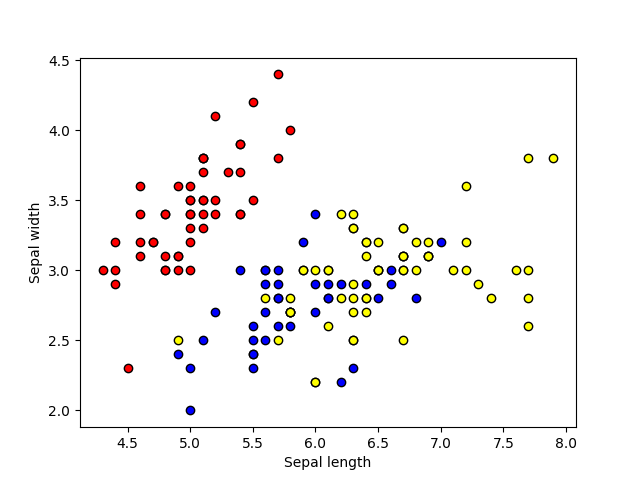

In [11]:
plt.close(2)
plt.figure(2)
for ii in range(3):
    inds = y==(ii+1)
    plt.scatter(X[inds, 0], X[inds, 1], c=colordict[ii], edgecolor="k", label=iris.target_names[ii])
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.show()

In [12]:
dim = 2
num_classes = 3
func_name = 'nn'
if func_name == 'linear':
    num_params = (dim+1)*num_classes
    func = linear_func
else:
    num_hidden = 5
    num_params = num_hidden + (num_hidden * dim) + num_classes + (num_classes * num_hidden)
    func = lambda x, params: nn_func(x, params, num_hidden_units=num_hidden)
loglike = lambda params: log_likelihood(params, X, yhat, func)
logpost = lambda params: log_posterior(params, loglike, log_prior_gaussian)
print(f"Inferring with {func_name}: number of parameters = {num_params}")

Inferring with nn: number of parameters = 33


In [13]:
guess = np.random.randn((num_params)) # random guess
map_point, cov_laplace = laplace_approx(guess, logpost)
map_point

array([-1.62466417,  0.52078634, -0.52078499,  1.62468096, -0.520785  ,
        0.32205777, -0.08386168, -0.78964289,  1.20549969,  0.78964123,
       -1.20549736, -0.32206428,  0.0838699 ,  0.78964099, -1.20549688,
        0.29022726,  0.01881356, -0.30904424, -0.70165017,  1.3933679 ,
       -1.39336679,  0.70166154, -1.39336554, -0.73723471, -0.76016981,
        0.76016622,  0.73723545,  0.76016557,  1.43888248, -0.63320025,
        0.63319821, -1.43889801,  0.63319868])

Lets visualize the predictor. We will visualize the probabilities of each class, the class with the highest probability, and the entropy of the prediction. The entry is loosly a measure of uncertainty in the prediction. For discrete random variables it is calculated as

$$
\begin{equation}
H(p) = - \sum_{i=1}^n p_i \log p_i
\end{equation}
$$

In [14]:
def visualize_predictor(fignum, param, title):
    N = 60
    M = 50

    xmin = np.min(X[:, 0])
    xmax = np.max(X[:, 0])
    ymin = np.min(X[:, 1])
    ymax = np.max(X[:, 1])
    x = np.linspace(xmin, xmax, N)
    ylin = np.linspace(ymin, ymax, M)
    xx, yy = np.meshgrid(x, ylin)
    xy = np.array([xx.flatten(), yy.flatten()]).T  # this is now a NN x 2 array
    p, norms, _ = predictor(param, xy, func)

    fig, axs = plt.subplots(1, 2, num=fignum+1, figsize=(8,4))
    vals = np.argmax(p, axis=1)
    cf = axs[0].contourf(xx, yy, vals.reshape((M, N)), alpha=0.8)
    plt.colorbar(cf, ax=axs[0])
    for ii in range(3):
        inds = y==(ii+1)
        axs[0].scatter(X[inds, 0], X[inds, 1], c=colordict[ii], edgecolor="k", label=iris.target_names[ii])
    axs[0].set_title("Most Likely")

    entropy = - np.sum(p * np.log(p), axis=1)
    cf = axs[1].contourf(xx, yy, entropy.reshape((M, N)), alpha=0.8)
    plt.colorbar(cf, ax=axs[1])
    for ii in range(3):
        inds = y==(ii+1)
        axs[1].scatter(X[inds, 0], X[inds, 1], c=colordict[ii], edgecolor="k", label=iris.target_names[ii])
    axs[1].set_title("Entropy (Uncertainty) of Prediction")


    fig, axs = plt.subplots(1, 3, num=fignum, figsize=(10,4))
    for jj in range(3):
        probs = p[:, jj].reshape((M, N))
        cf = axs[jj].contourf(xx, yy, probs, alpha=0.8)
        for ii in range(3):
            inds = y==(ii+1)
            axs[jj].scatter(X[inds, 0], X[inds, 1], c=colordict[ii], edgecolor="k", label=iris.target_names[ii])
        axs[jj].set_xlabel("Sepal length")
        axs[jj].set_ylabel("Sepal width")
        #axs[jj].ticks(fontsize=14)
        #axs[jj].yticks(fontsize=14)
        plt.colorbar(cf, ax=axs[jj])
        axs[jj].set_title(f"Class {jj+1}")
        if jj == 0:
            axs[jj].legend()
    plt.suptitle('Predictor probability')

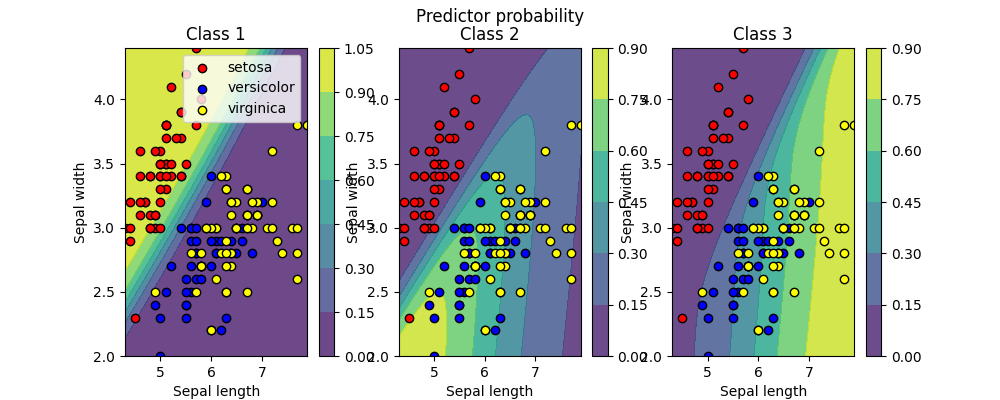

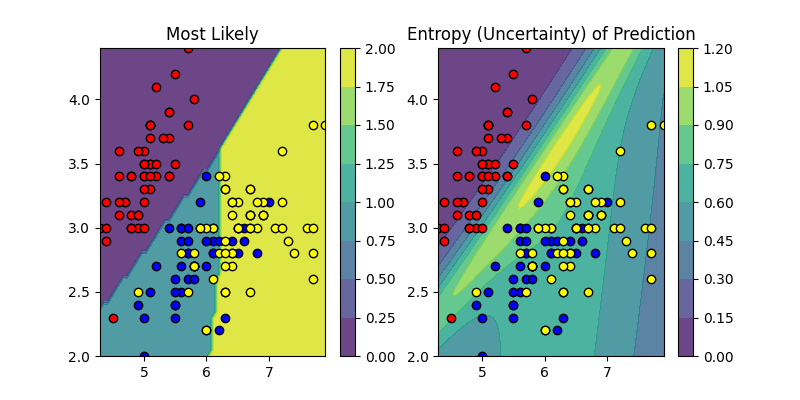

In [15]:
plt.close(3)
plt.close(4)
visualize_predictor(3, map_point, "MAP predictor")
plt.show()

## MCMC

Next we use the Laplace approximation to initialize and run MCMC

In [16]:
num_samples = 60000
initial_sample = map_point
cov = cov_laplace

# setup proposal
#am = AdaptiveMetropolis(logpost, cov, sd=2.0, t0=1000, max_samples=num_samples)
am = AdaptiveMetropolis(logpost, 2e-1 * cov, sd=0.1, t0=5, max_samples=num_samples)

samples = am.sample(initial_sample, num_samples)

Finished sample 1000, acceptance ratio = 0.986
Finished sample 2000, acceptance ratio = 0.9625
Finished sample 3000, acceptance ratio = 0.9386666666666666
Finished sample 4000, acceptance ratio = 0.912
Finished sample 5000, acceptance ratio = 0.89
Finished sample 6000, acceptance ratio = 0.8723333333333333
Finished sample 7000, acceptance ratio = 0.8531428571428571
Finished sample 8000, acceptance ratio = 0.837125
Finished sample 9000, acceptance ratio = 0.8175555555555556
Finished sample 10000, acceptance ratio = 0.8037
Finished sample 11000, acceptance ratio = 0.7910909090909091
Finished sample 12000, acceptance ratio = 0.7796666666666666
Finished sample 13000, acceptance ratio = 0.7711538461538462
Finished sample 14000, acceptance ratio = 0.7623571428571428
Finished sample 15000, acceptance ratio = 0.7531333333333333
Finished sample 16000, acceptance ratio = 0.747375
Finished sample 17000, acceptance ratio = 0.740764705882353
Finished sample 18000, acceptance ratio = 0.7319444444444

Next lets discard burn-in and then sub-sample to make post-processing a little faster

In [17]:
samples_sub = sub_sample_data(samples, frac_burn=0.5, frac_use=0.5)

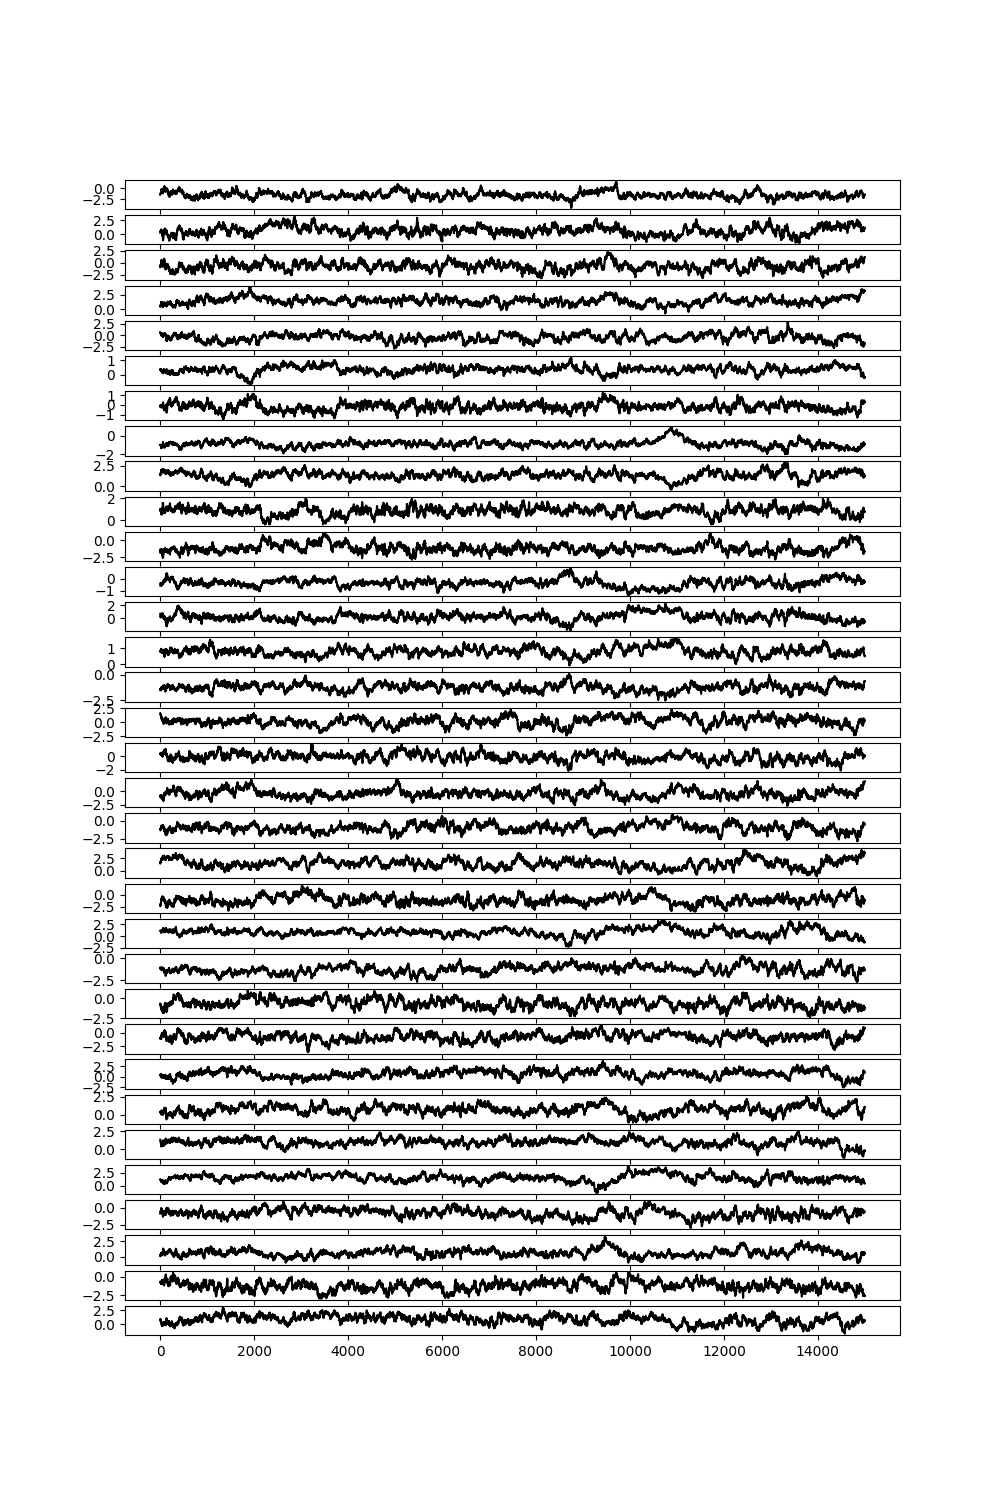

In [18]:
plt.close(5)
fig, axs = plt.subplots(num_params,1, figsize=(10,15), num=5)
for ii in range(num_params):
    axs[ii].plot(samples_sub[:, ii], '-k')
#plt.tight_layout()

/Users/goroda/Teaching/inference_estimation/code/jupyter_lab/BayesianInference/mcmc/LiveDemos/mcmc_utils_and_plot.py:250: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(pad=0.01);


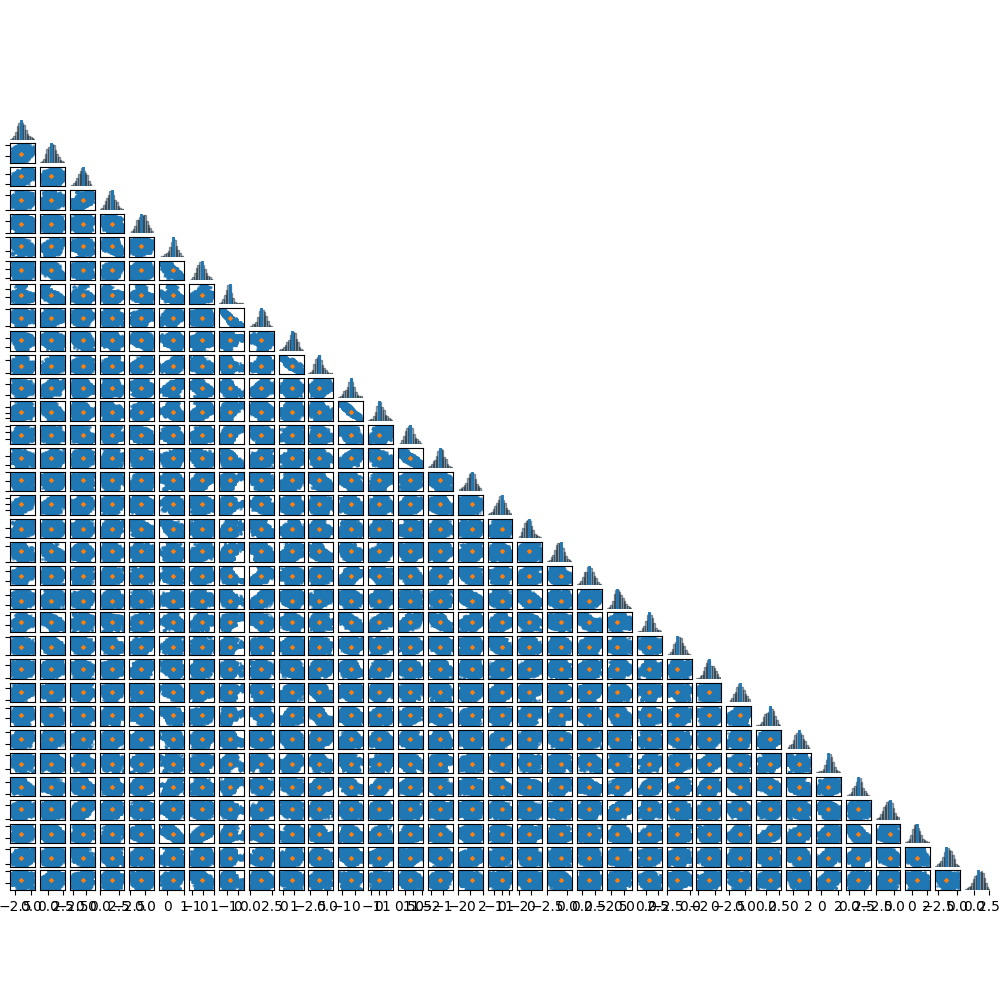

In [19]:
plt.close(6)
fig, axs, gs = scatter_matrix(6, [samples_sub], hist_plot=False, gamma=0.2, specials={"vals":map_point})
fig.set_size_inches(10,10)
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.2, hspace=0.2)

Now lets visualize the averaged predictor

$$
\begin{equation}
\mathbb{E}\left[g(x;\theta)\right] \qquad \theta \sim p(\theta \mid D)
\end{equation}
$$

In [20]:
def visualize_predictor_avg(fignum, samples, title):
    N = 60
    M = 50

    xmin = np.min(X[:, 0])
    xmax = np.max(X[:, 0])
    ymin = np.min(X[:, 1])
    ymax = np.max(X[:, 1])
    x = np.linspace(xmin, xmax, N)
    ylin = np.linspace(ymin, ymax, M)
    xx, yy = np.meshgrid(x, ylin)
    xy = np.array([xx.flatten(), yy.flatten()]).T  # this is now a NN x 2 array

    num_samples = samples.shape[0]
    pred = np.zeros((xy.shape[0], 3))
    for jj in range(num_samples):
        p, norms, _ = predictor(samples[jj, :], xy, func)
        pred += p
    pred /= num_samples

    fig, axs = plt.subplots(1, 2, num=fignum+1)
    vals = np.argmax(pred, axis=1)
    cf = axs[0].contourf(xx, yy, vals.reshape((M, N)), alpha=0.8)
    plt.colorbar(cf, ax=axs[0])
    for ii in range(3):
        inds = y==(ii+1)
        axs[0].scatter(X[inds, 0], X[inds, 1], c=colordict[ii], edgecolor="k", label=iris.target_names[ii])
    axs[0].set_title("Most Likely")

    entropy = - np.sum(pred * np.log(pred), axis=1)
    cf = axs[1].contourf(xx, yy, entropy.reshape((M, N)), alpha=0.8)
    plt.colorbar(cf, ax=axs[1])
    for ii in range(3):
        inds = y==(ii+1)
        axs[1].scatter(X[inds, 0], X[inds, 1], c=colordict[ii], edgecolor="k", label=iris.target_names[ii])
    axs[1].set_title("Entropy (Uncertainty) of Prediction")

    fig, axs = plt.subplots(1, 3, num=fignum, figsize=(8,4))
    for jj in range(3):
        probs = pred[:, jj].reshape((M, N))
        cf = axs[jj].contourf(xx, yy, probs, alpha=0.8)
        for ii in range(3):
            inds = y==(ii+1)
            axs[jj].scatter(X[inds, 0], X[inds, 1], c=colordict[ii], edgecolor="k", label=iris.target_names[ii])
        axs[jj].set_xlabel("Sepal length")
        axs[jj].set_ylabel("Sepal width")
        #axs[jj].ticks(fontsize=14)
        #axs[jj].yticks(fontsize=14)
        plt.colorbar(cf, ax=axs[jj])
        axs[jj].set_title(f"Class {jj+1}")
        if jj == 0:
            axs[jj].legend()
    plt.suptitle("Prediction")


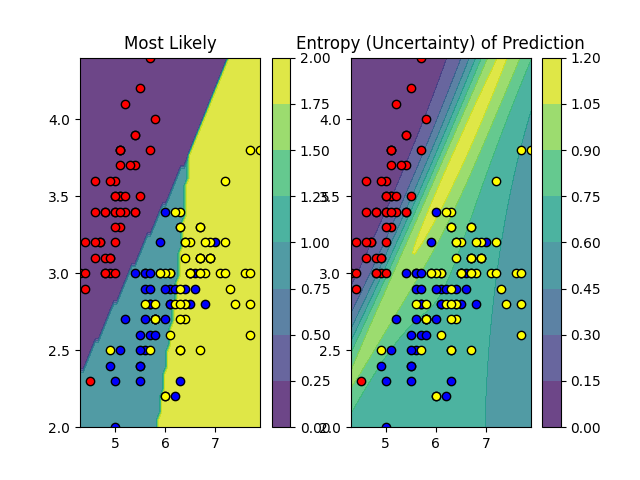

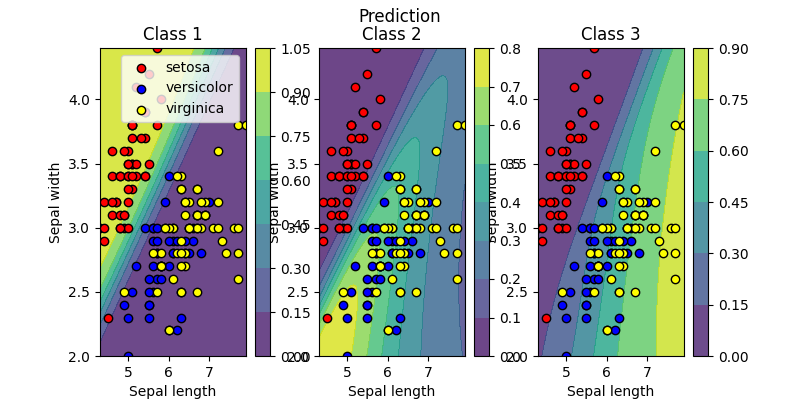

In [21]:
# plt.close('all')
plt.close(7)
plt.close(8)
visualize_predictor_avg(7, samples_sub, "Posterior Predictive")

For the record lets repeat the MAP estimate

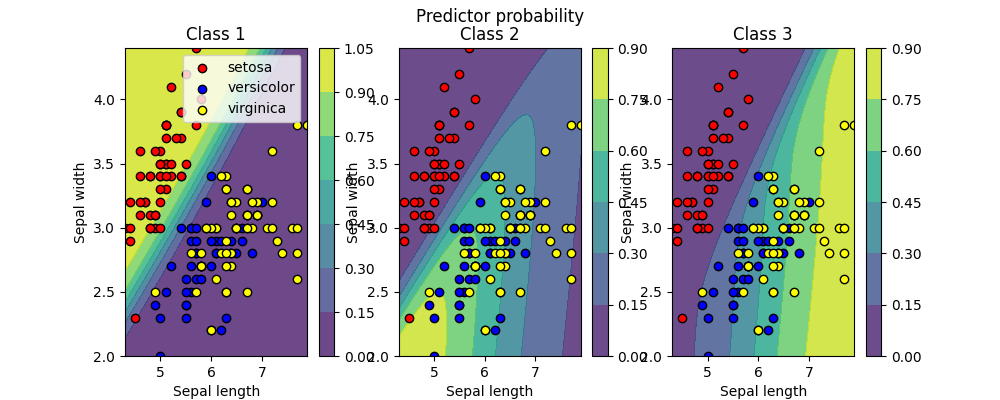

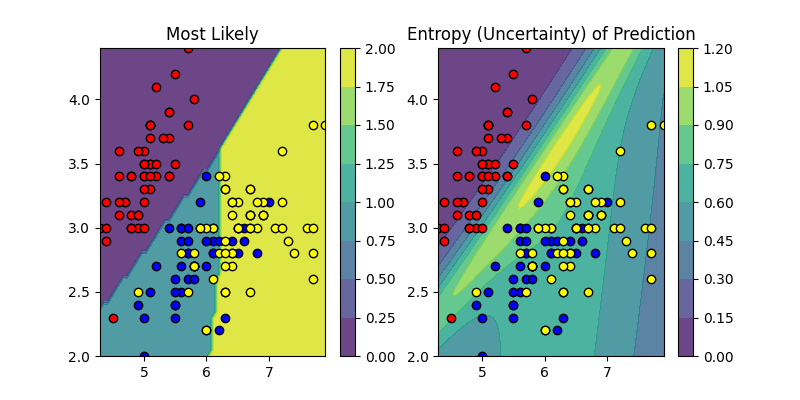

In [22]:
plt.close(9)
visualize_predictor(9, map_point, "MAP")
plt.show()

We can also look at the uncertainty in the predictions. Here we are looking at the 

$$
\begin{equation}
\mathbb{V}ar[g_i(x; \theta)], \quad \theta \sim p(\theta \mid d)
\end{equation}
$$

In [23]:
def visualize_predictor_var(fignum, samples, title):
    N = 60
    M = 50

    xmin = np.min(X[:, 0])
    xmax = np.max(X[:, 0])
    ymin = np.min(X[:, 1])
    ymax = np.max(X[:, 1])
    x = np.linspace(xmin, xmax, N)
    ylin = np.linspace(ymin, ymax, M)
    xx, yy = np.meshgrid(x, ylin)
    xy = np.array([xx.flatten(), yy.flatten()]).T  # this is now a NN x 2 array

    num_samples = samples.shape[0]
    pred = np.zeros((xy.shape[0], 3, samples.shape[0]))
    for jj in range(samples.shape[0]):
        pred[:, :, jj], norms, _ = predictor(samples[jj, :], xy, func)

    pred_var = np.var(pred, axis=2)

    fig, axs = plt.subplots(1, 3, figsize=(9,5), num=fignum)
    for jj in range(3):
        probs = pred_var[:, jj].reshape((M, N))
        cf = axs[jj].contourf(xx, yy, probs, alpha=0.8)
        for ii in range(3):
            inds = y==(ii+1)
            axs[jj].scatter(X[inds, 0], X[inds, 1], c=colordict[ii], edgecolor="k", label=iris.target_names[ii])
        axs[jj].set_xlabel("Sepal length")
        axs[jj].set_ylabel("Sepal width")
        #axs[jj].ticks(fontsize=14)
        #axs[jj].yticks(fontsize=14)
        plt.colorbar(cf, ax=axs[jj])
        axs[jj].set_title(f"Class {jj+1}")
        if jj == 0:
            axs[jj].legend()

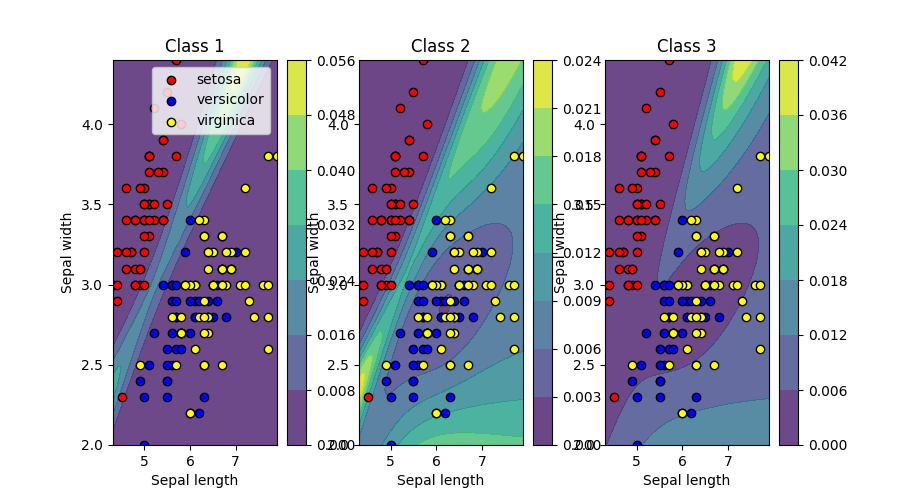

In [24]:
plt.close(11)
visualize_predictor_var(11, samples_sub, "Variance")
plt.show()

Here we see that the greatest uncertainty lies where there is a lack of data. Contrast this with the actual probabilities that we looked at previously

Finally, lets look at some samples

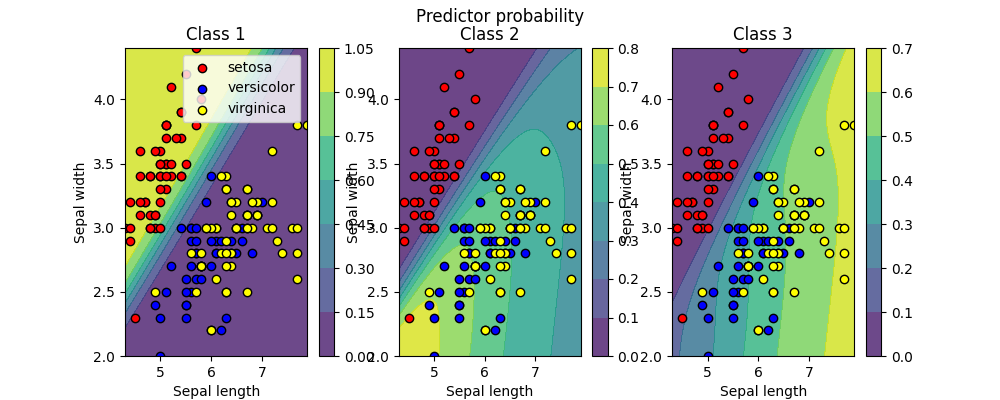

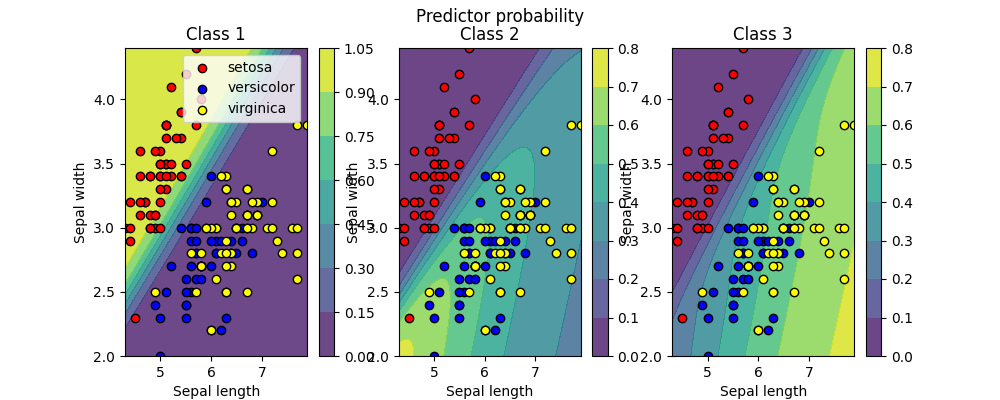

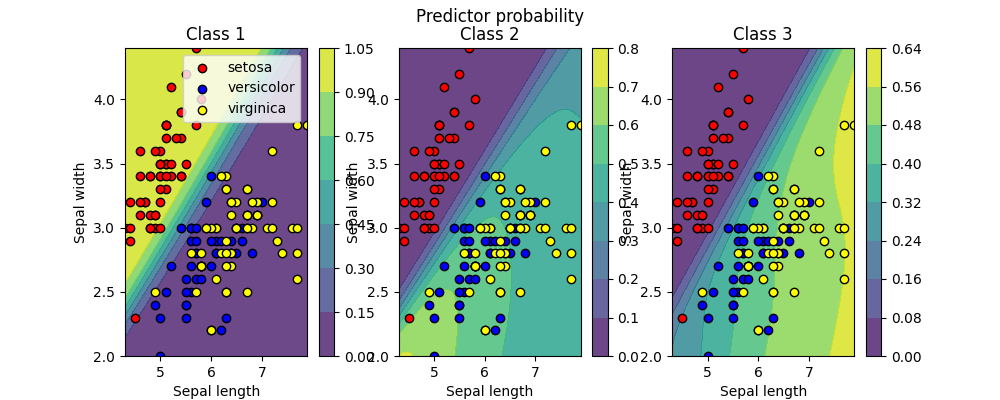

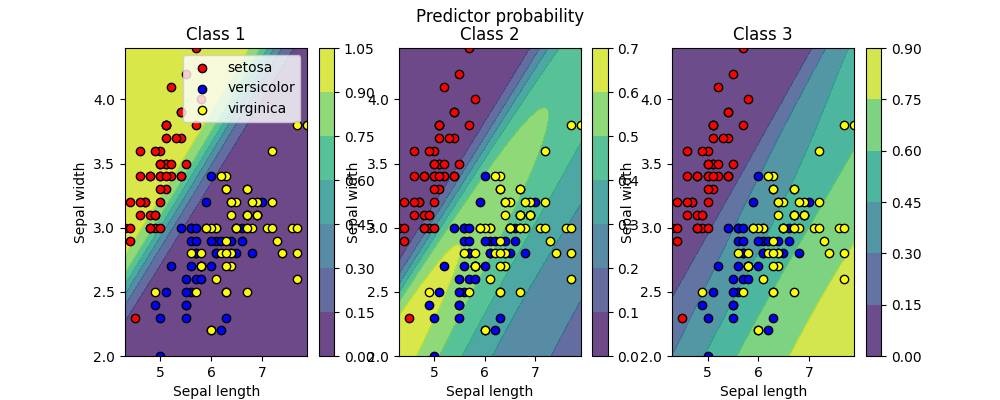

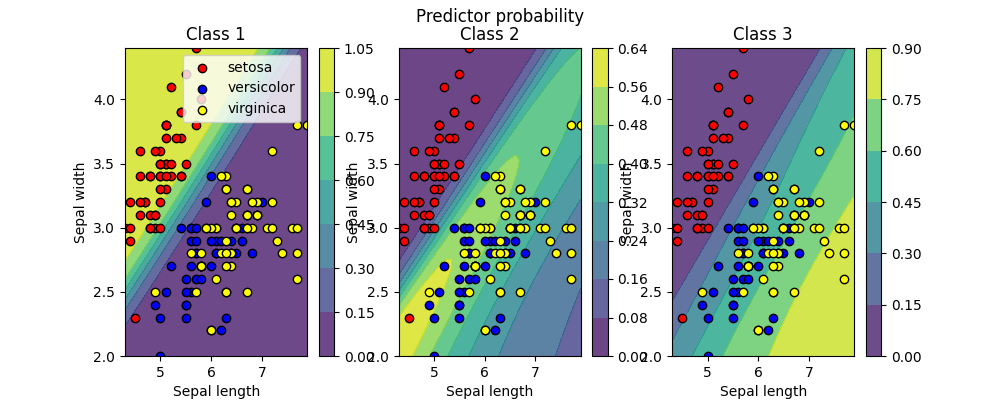

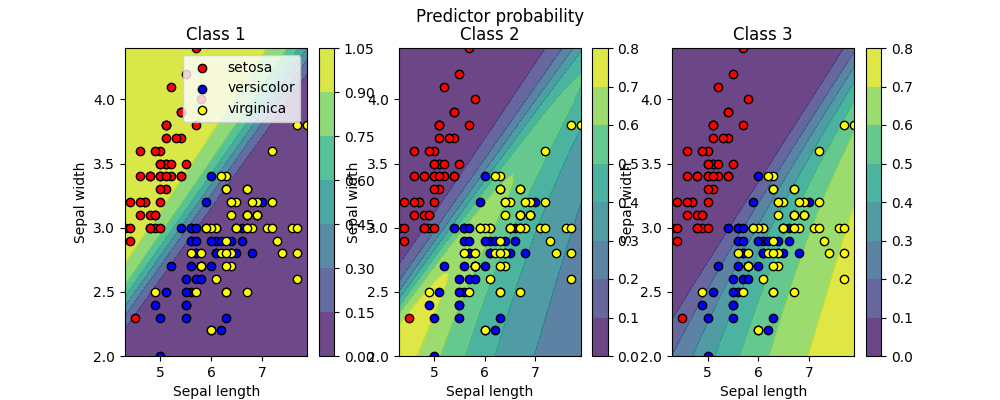

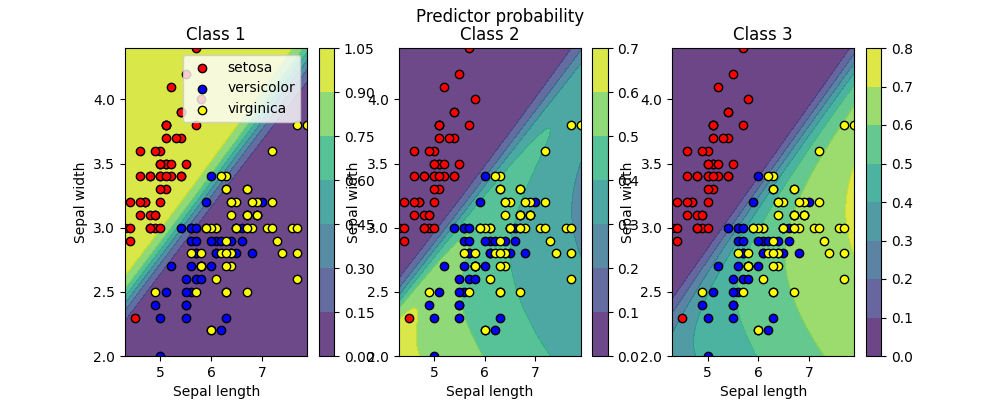

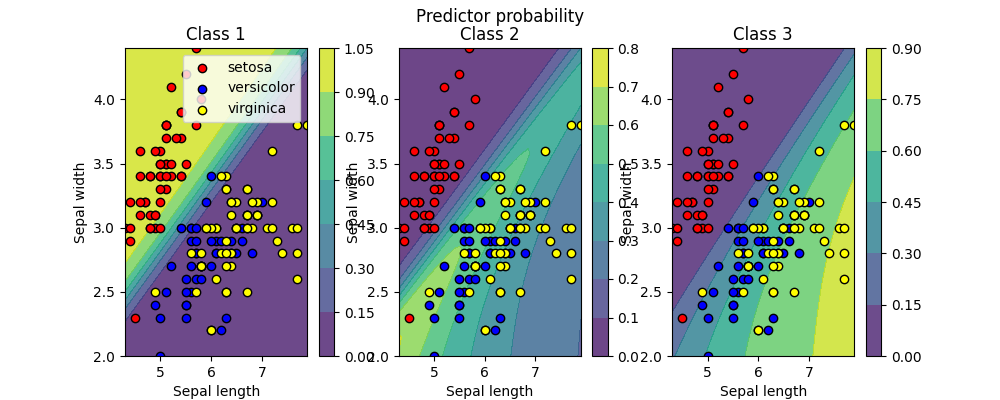

/var/folders/gw/hg0bj8tj0rzb63d9mz55kzhm0000gn/T/ipykernel_61832/1048337738.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 3, num=fignum, figsize=(10,4))


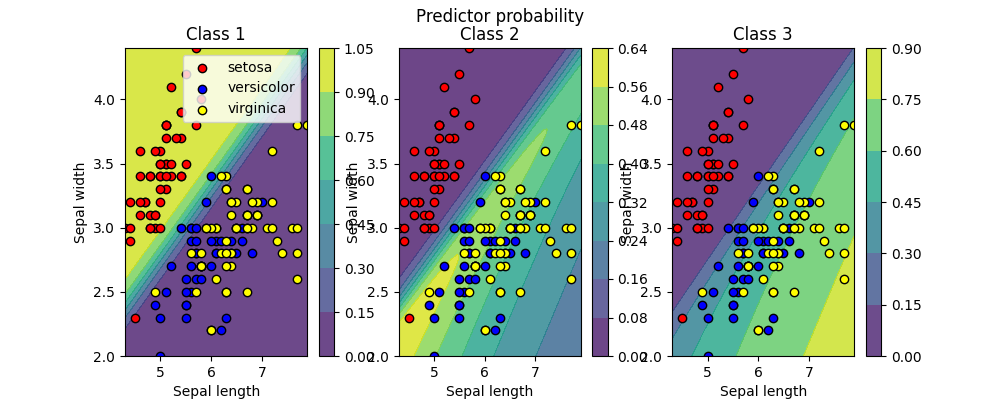

/var/folders/gw/hg0bj8tj0rzb63d9mz55kzhm0000gn/T/ipykernel_61832/1048337738.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, num=fignum+1, figsize=(8,4))


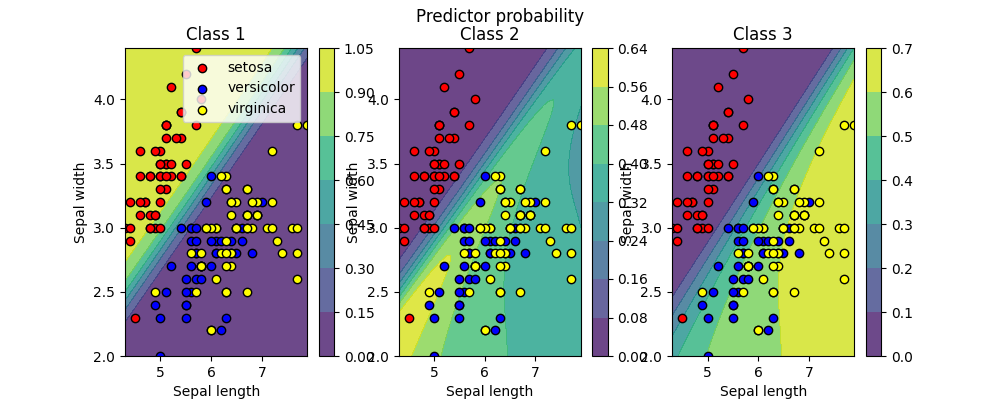

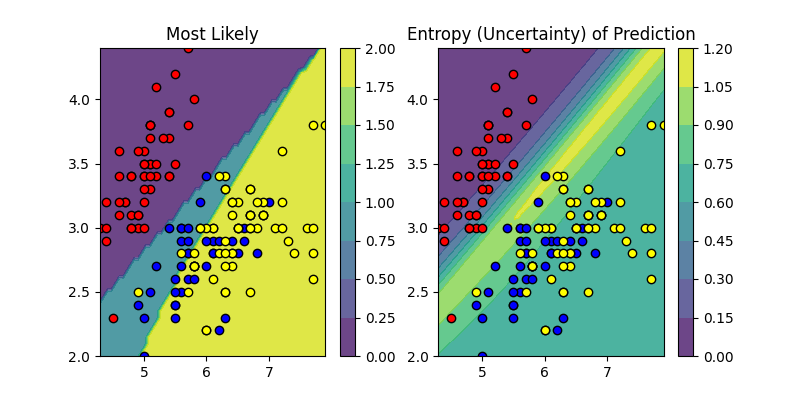

In [25]:
for ii in range(10):
    plt.close(12+ii)
    visualize_predictor(12 + ii, samples_sub[ii*10, :], "Posterior Sample")
    plt.show()